# Development Jupyter notebook for Student rersearch paper

This Jupyter notebook is documenting the process and test cases for the student research paper:
> *Critical clearing time of synchronous generators*

This notebook is showing the design thinking process of the modelling and its results (plots, values, etc.). The main functions, algorithms and calculations are exported in a seperate `.py`-file and included in the Appendix of the thesis itself.

Background and contents of the thesis are given by following bullet points. Relevant for model generation and implementation are marked:<br>
- Swing equation of synchronous generators
- **Solving the Swing equation** with the help of Python (Second order ODE)
- Deriving the Equal-area criterion
- **Simulation of a fault** and **applying the equal-area criteria** with the help of Python.
- Comparison between analytical and (numerical) simulation results

## 1 Fundamentals and assumptions

### 1.1 Swing equation - describing dynamic behavior of synchronous generators

The basic swing equations can be derived to:
$$
\frac{d\delta}{dt}=\Delta\omega\\[12pt]
\frac{d\Delta\omega}{dt}=\frac{1}{2 \cdot H_\mathrm{gen}} \cdot (P_\mathrm{m} - P_\mathrm{e})
$$
whereas $P_\mathrm{m}$ can be set to a constant value, due to the transient (short-timed) nature of fault analysis, and $P_\mathrm{e}$ can be set $0$ for a three-phase fault near the generator.

Generally only three-phase faults are considered, due to the simpler calculation and bigger impact. In addition to the generator-near line fault, a fault on a bus far away (end of a transmission line), and a fault on one of the transmission lines while still delivering power over the remaining one is included.

### 1.2 Load flow analysis and initial value determination

## 2 Implementation and TDS solving of the ODE system

For the solving of the ODE system, python's internal methods and functions shall be used.

### 2.1 Imports and pre-definitions

In [217]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.integrate import odeint, RK45

# helping function for calculation with complex numbers
def mag_and_angle_to_cmplx(mag, angle):
    return mag * np.exp(1j * angle)

# variable setting
fn = 60
H_gen = 3.5
X_gen = 0.2
X_ibb = 0.1
X_line = 0.65

# Values are initialized from loadflow
E_fd_gen = 1.075
E_fd_ibb = 1.033
P_m_gen = 1998/2200

omega_gen_init = 0
delta_gen_init = np.deg2rad(45.9)
# delta_gen_init = np.deg2rad(43.22)
delta_ibb_init = np.deg2rad(-5.0)

# simulation setups
t_start = 0
t_end = 5
t_step = 0.001

fault_start = 1
fault_end = 1.125

Defining some helping functions for determing the grid demanded electrical Power $P_\mathrm{e}$ and the mechanical power $P_\mathrm{m}$ from the Turbine.

In [218]:
def P_e(E_1, E_2, X, delta):
    P_e_gen = (E_1 * E_2) / X * np.sin(delta)
    return P_e_gen

def P_m(omega):
    global P_m_gen
    global omega_gen_init
    P_t = P_m_gen / (1 + (omega_gen_init + omega))
    return P_t

def algebraic(delta_gen, fault_on):
    # If the SC is on, the admittance matrix is different.
    # The SC on busbar 0 is expressed in the admittance matrix as a very large admittance (1000000) i.e. a very small impedance.
    if fault_on:
        y_adm = np.array([[(-1j / X_gen - 1j / X_line) + 1000000, 1j / X_line],
                          [1j / X_line, -1j / X_line - 1j / X_ibb]])
    else:
        y_adm = np.array([[-1j / X_gen - 1j / X_line, 1j / X_line],
                          [1j / X_line, -1j / X_line - 1j / X_ibb]])

    # Calculate the inverse of the admittance matrix (Y^-1)
    y_inv = np.linalg.inv(y_adm)

    # Calculate current injections of the generator and the infinite busbar
    i_inj_gen = mag_and_angle_to_cmplx(E_fd_gen, delta_gen) / (1j * X_gen)
    i_inj_ibb = mag_and_angle_to_cmplx(E_fd_ibb, delta_ibb_init) / (1j * X_ibb)

    # Calculate voltages at the bus by multiplying the inverse of the admittance matrix with the current injections
    v_bb_gen = y_inv[0, 0] * i_inj_gen + y_inv[0, 1] * i_inj_ibb
    v_bb_ibb = y_inv[1, 0] * i_inj_gen + y_inv[1, 1] * i_inj_ibb

    return v_bb_gen

Defining / Implementing the swing equation(s), in order to solve it with `odeoint` and `RK45` functions from the package `scipy.integrate`.

In [219]:
def ODE_system(state, t):
    omega, delta = state

    global H_gen
    global E_fd_gen
    global E_fd_ibb
    global X_gen
    global X_line
    global fault_start
    global fault_end
    global fn

    if fault_start <= t < fault_end:
        fault_on = True
    else:
        fault_on = False

    # including time dependent solving of algebraic equations
    v_bb_gen = algebraic(delta, fault_on)

    E_gen_complex = mag_and_angle_to_cmplx(E_fd_gen, delta)
    P_e_gen = (v_bb_gen * np.conj((E_gen_complex - v_bb_gen) / (1j * X_gen))).real
    
    d_omega_dt = 1 / (2 * H_gen) * (P_m(omega) - P_e_gen)
    d_delta_dt = omega * 2 * np.pi * fn

    return [d_omega_dt, d_delta_dt]

def rk_system(t, state):
    return ODE_system(state, t)

### 2.2 Solving with `odeint`

Simulation setup, solving and plotting of the results:

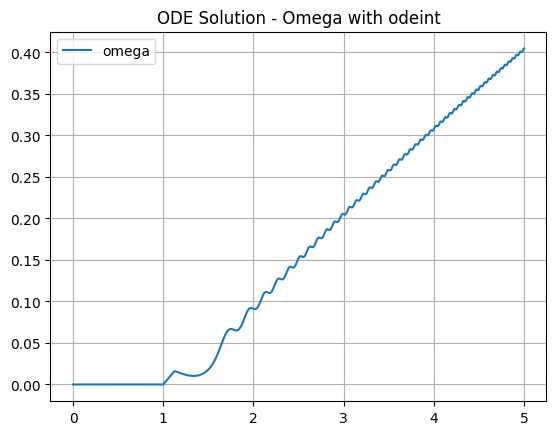

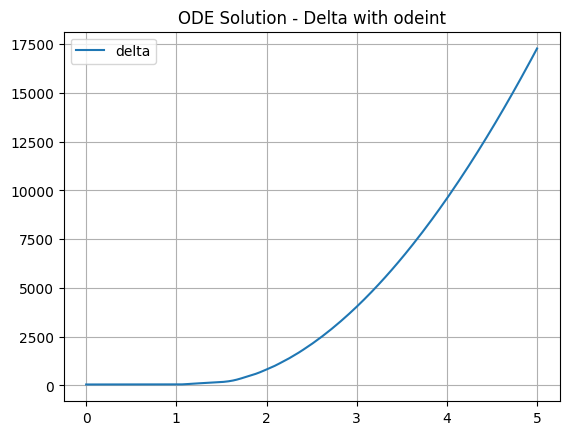

In [220]:
# setup simulation inputs 
t_sim = np.arange(t_start, t_end, t_step)
initial_conditions = [omega_gen_init, delta_gen_init]

# solve ODE with python solver
solution = odeint(ODE_system, initial_conditions, t_sim)

# save solution
omega = solution[:, 0]
delta = solution[:, 1]

# plotting of results
plt.plot(t_sim, omega, label='omega')
plt.legend()
plt.grid()
plt.title('ODE Solution - Omega with odeint')
plt.show()

plt.plot(t_sim, np.rad2deg(delta), label='delta')
plt.legend()
plt.grid()
plt.title('ODE Solution - Delta with odeint')
plt.show()

### 2.3 Solving with `RK45`

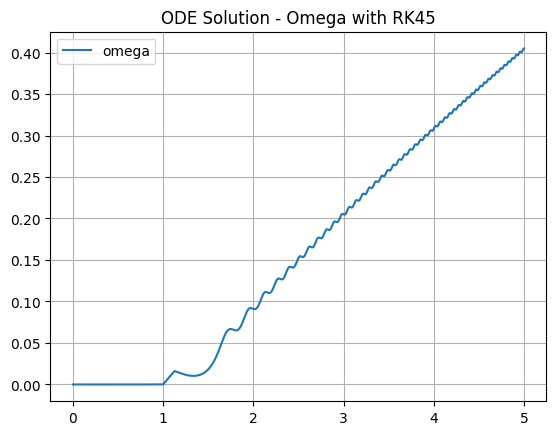

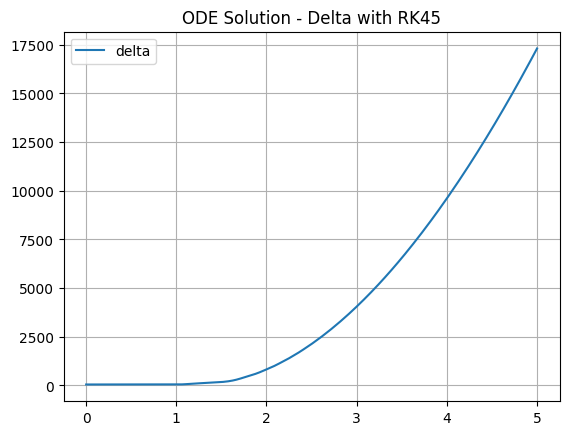

In [221]:
# same setup, solving with RK45

rk = RK45(rk_system, t_start, [omega_gen_init, delta_gen_init], t_end, max_step=t_step)

# save solution
t_rk = []
omega_rk = []
delta_rk = []

for i in range(np.size(t_sim)):
    # get solution step state
    rk.step()
    t_rk.append(rk.t)
    omega_rk.append(rk.y[0])
    delta_rk.append(rk.y[1])
    # break loop after modeling is finished
    if rk.status == 'finished':
        break

# plotting of results
plt.plot(t_rk, omega_rk, label='omega')
plt.legend()
plt.grid()
plt.title('ODE Solution - Omega with RK45')
plt.show()

plt.plot(t_rk, np.rad2deg(delta_rk), label='delta')
plt.legend()
plt.grid()
plt.title('ODE Solution - Delta with RK45')
plt.show()

### 2.4 Heun's method

Python does not provide this method. Following the computation of a solver for Heun's method. 

### 2.5 Comparison

Comparison between `odeint` and `RK45`:

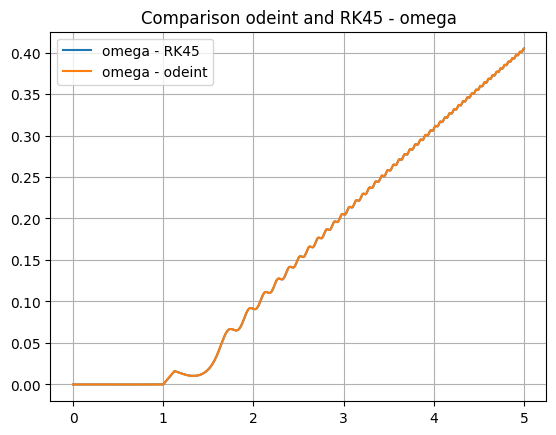

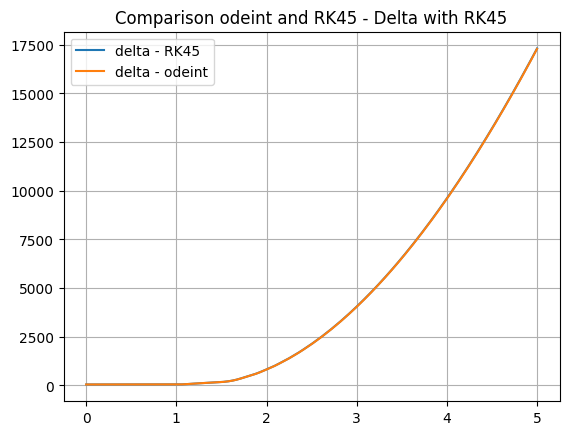

In [222]:
plt.plot(t_rk, omega_rk, label='omega - RK45')
plt.plot(t_sim, omega, label='omega - odeint')
plt.legend()
plt.grid()
plt.title('Comparison odeint and RK45 - omega')
plt.show()

plt.plot(t_rk, np.rad2deg(delta_rk), label='delta - RK45')
plt.plot(t_sim, np.rad2deg(delta), label='delta - odeint')
plt.legend()
plt.grid()
plt.title('Comparison odeint and RK45 - Delta with RK45')
plt.show()

**Observations:**<br>
1. No observable difference in result quality, if the max. step size is the same
2. With default `max_step=np.inf`, `RK45`-solver performs worse
3. `odeint`-solver easier to set up compared to `RK45`-solver

## 3 Implementing EAC and determing stability angle and time

In [223]:
# todo: All calculations and variables in rad; output in deg; calculate stability margin
# Problem: clearing modus und nicht stable -> falsche Rückgabe

delta_0 = delta_gen_init # later: calculation via P-delta curve
delta_max = np.pi - delta_0

def P_r_deg(delta, E1, E2, X):
    # determing the P_e curve under input in degrees
    return (E1*E2)/(X)*np.sin(delta) - P_m_gen

def P_t_deg(x):
    # determing the P_t curve under input in degrees
    return P_m_gen*np.ones(np.size(x))

def stability_eac_clearing(delta_0, delta_act, delta_max, E_p, E_k_pre, E_k_post, X_pre, X_post):
    # Compare the acceleration area until the given delta and compare it to the braking area left until the dynamic stability point is passed
    area_acc = sp.integrate.quad(P_r_deg, delta_0, delta_act, args=(E_p, E_k_post, X_post))
    area_dec = sp.integrate.quad(P_r_deg, delta_act, delta_max, args=(E_p, E_k_pre, X_pre))

    if abs(area_acc[0]) < abs(area_dec[0]): # True: stable, False: NOT stable 
        return True
    else:
        return False

def stability_eac_non_clearing(delta_0, delta_act, delta_max, E_p, E_k_post, X_post):
    # Compare the acceleration area until the given delta and compare it to the braking area left until the dynamic stability point is passed
    area_acc = sp.integrate.quad(P_r_deg, delta_0, delta_act, args=(E_p, E_k_post, X_post))
    area_dec = sp.integrate.quad(P_r_deg, delta_act, delta_max, args=(E_p, E_k_post, X_post))

    if abs(area_acc[0]) < abs(area_dec[0]): # True: stable, False: NOT stable 
        return True
    else:
        return False

def determine_cct(mode, t_sim, delta, delta_0, E_p, E_k_pre, E_k_post, X_pre, X_post):
    # t_sim and delta are result arrays
    # delta_0 is the initial angle delta of the stable system pre-fault

    # Save current time and delta at time point i; iterate through i to test any given time until stability can't be remained; delta_cc and t_cc is the angle and time at the last stable point
    if mode == 'c':
        delta_max = np.pi - delta_0

        i = 0
        t_cc, delta_cc = -1, -1
        while stability_eac_clearing(delta_0, delta[i], delta_max, E_p, E_k_pre, E_k_post, X_pre, X_post) and i < np.size(t_sim)-1:
            t_cc = t_sim[i]
            delta_cc = delta[i]
            i = i + 1

        if t_cc < 0:
            return False, -1, -1
        else:
            return True, t_cc, delta_cc
            
    elif mode == 'nc':
        delta_max = np.pi - np.arcsin(P_m_gen/P_e(E_p, E_k_post, X_post, np.pi/2))

        if P_m_gen > P_e(E_p, E_k_post, X_post, np.pi/2):
            return False

        for i in range(np.size(t_sim)):
            if stability_eac_non_clearing(delta_0, delta[i], delta_max, E_p, E_k_post, X_post) == False:
                return False
        return True

# stability, t_cc, delta_cc = determine_cct('c', t_sim, delta, delta_0, E_fd_gen, E_fd_ibb, 0, (X_line + X_gen), X_gen)
# stability = determine_cct('c', t_sim, delta, delta_0, E_fd_gen, E_fd_ibb, E_fd_ibb, (X_line + X_gen), X_gen + 2*X_line)

# print(stability, t_cc, delta_cc)
# print('CCT: ' + str(t_cc) + ' s')
# print('CC angle: ' + str(round(np.rad2deg(delta_cc), 2)) + ' deg')

Plotting function: Plot all the functions with the form `P(delta)`, where the Power is given over the angle delta in rad. Inputs have to be the contributions to the demanded electrical power of the system $P_\mathrm{e}$ and the mode of failure. `'c'` for a fault, which is cleared after the critical clearing time $t_\mathrm{cc}$, `'nc'` is for a non-cleared fault, that possible offers a stable generator operation point with the reduced $P_\mathrm{e}$.

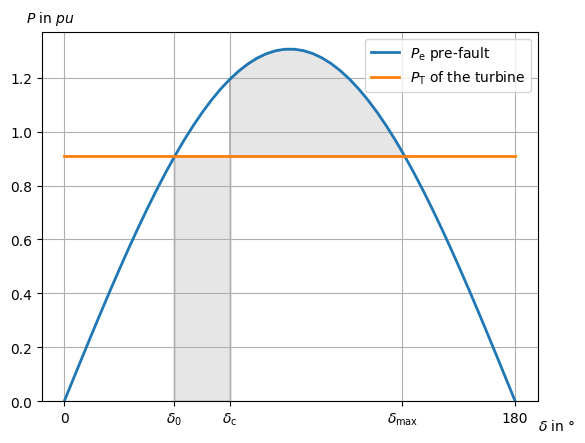

0.125 67.68163615840557


In [224]:
# todo: implement plot_post, auto_reclosing as input variables; different outputs in relation to that
# problem noch bei c und nc aber auch stable;

from matplotlib.patches import Polygon

def plot_P_delta(mode, E_p, E_k_pre, E_k_post, X_pre, X_post):
    # plotting of P - delta curve and the relavant areas. Consideration of pre- and post-fault function as partially sin-function in [0, 2*pi], as well as constant power function of the turbine
    # marking the critical power angle delta_c

    # calculation of P_e_pre, P_e_post, and P_t
    x_deg = np.linspace(0, 180) # linear vector for plotting in deg
    x_rad = np.linspace(0, np.pi) # linear vector for calculation in rad
    P_e_pre = P_e(E_p, E_k_pre, X_pre, x_rad)
    P_e_post = P_e(E_p, E_k_post, X_post, x_rad)
    P_t = P_t_deg(x_rad)

    # setting up the plot and plotting P_e and P_t
    fig, ax = plt.subplots()
    ax.plot(x_deg, P_e_pre, '-', linewidth=2, label='$P_\mathrm{e}$ pre-fault')
    if P_e(E_p, E_k_post, X_post, np.pi/2)!= 0:
        ax.plot(x_deg, P_e_post, '-', linewidth=2, label='$P_\mathrm{e}$ post-fault')
    ax.plot(x_deg, P_t, '-', linewidth=2, label='$P_\mathrm{T}$ of the turbine')

    # Determing the boundary angles
    delta_0 = np.arcsin(P_m_gen/P_e(E_p, E_k_pre, X_pre, np.pi/2))

    ax.set_ylim(bottom=0)
    if mode == 'c':
        delta_max = np.pi - delta_0
        stability, t_cc, delta_c = determine_cct(mode, t_sim, delta, delta_0, E_p, E_k_pre, E_k_post, X_pre, X_post)

        delta_0_deg = int(np.rad2deg(delta_0))
        delta_max_deg = int(np.rad2deg(delta_max))
        delta_c_deg = int(np.rad2deg(delta_c))

        if stability:
            # Make the shaded region for area_acc
            ix1 = np.linspace(delta_0_deg, delta_c_deg)
            iy1 = P_e(E_p, E_k_post, X_post, np.deg2rad(ix1))
            ax.fill_between(ix1, iy1, P_m_gen, facecolor='0.9', edgecolor='0.5')

            # Make the shaded region for area_dec, https://matplotlib.org/stable/gallery/lines_bars_and_markers/fill_between_demo.html
            ix2 = np.linspace(delta_c_deg, delta_max_deg) # -> does this have to be in rad or in deg?
            iy2 = P_e(E_p, E_k_pre, X_pre, np.deg2rad(ix2))
            ax.fill_between(ix2, iy2, P_m_gen, facecolor='0.9', edgecolor='0.5')

            ax.set_xticks([0, 180, delta_0_deg, delta_c_deg, delta_max_deg], labels=['0', '180', '$\delta_\mathrm{0}$', '$\delta_\mathrm{c}$', '$\delta_\mathrm{max}$'])
        else:
            ix1 = np.linspace(delta_0_deg, delta_max_deg)
            iy1 = np.zeros(np.size(ix1))
            ax.fill_between(ix1, iy1, P_m_gen, facecolor='red', edgecolor='red', alpha=0.5)
    elif mode == 'nc':
        if P_m_gen > P_e(E_p, E_k_post, X_post, np.pi/2):
            delta_max = np.pi
        else:
            delta_max = np.pi - np.arcsin(P_m_gen/P_e(E_p, E_k_post, X_post, np.pi/2))
        
        stability = determine_cct(mode, t_sim, delta, delta_0, E_p, E_k_pre, E_k_post, X_pre, X_post)

        delta_0_deg = int(np.rad2deg(delta_0))
        delta_max_deg = int(np.rad2deg(delta_max))
        
        if stability:
            # Make the shaded region for area_acc
            ix1 = np.linspace(delta_0_deg, delta_max_deg) # -> does this have to be in rad or in deg?
            iy1 = P_e(E_p, E_k_post, X_post, np.deg2rad(ix1))
            ax.fill_between(ix1, iy1, P_m_gen, facecolor='0.9', edgecolor='0.5')

            ax.set_xticks([0, 180, delta_0_deg, delta_max_deg], labels=['0', '180', '$\delta_\mathrm{0}$', '$\delta_\mathrm{max}$'])
        else:
            # Make the shaded region for area_acc
            ix1 = np.linspace(delta_0_deg, delta_max_deg) # -> does this have to be in rad or in deg?
            iy1 = P_e(E_p, E_k_post, X_post, np.deg2rad(ix1))
            ax.fill_between(ix1, iy1, P_m_gen, facecolor='red', edgecolor='red', alpha=.5)

            ax.set_xticks([0, 180, delta_0_deg, delta_max_deg], labels=['0', '180', '$\delta_\mathrm{0}$', '$\delta_\mathrm{max}$'])

        
    # adding area descriptions
    # ax.text(0.5*(delta_0_deg + delta_c_deg), P_m_gen-0.1, r"$A_\mathrm{acc}$", horizontalalignment='center', fontsize=15)
    # ax.text(0.47*(delta_max_deg + delta_c_deg), P_m_gen+0.05, r"$A_\mathrm{dec}$", horizontalalignment='center', fontsize=15)
    # 0.3*(P_e(E_p, E_k_pre, X_pre, np.pi/2) - P_m_gen)

    # axis text and optical manipulation of the plot
    fig.text(0.9, 0.05, '$\delta$ in $°$')
    fig.text(0.1, 0.9, '$P$ in $pu$')

    plt.grid()
    plt.legend()
    plt.show()
    return

plot_P_delta('c', E_fd_gen, E_fd_ibb, 0, (X_line + X_gen), X_gen)
stable_det, cct, delta_cct = determine_cct('c', t_sim, delta, delta_gen_init, E_fd_gen, E_fd_ibb, 0, (X_line + X_gen), X_gen)

print(cct-1, np.rad2deg(delta_cct))

# plot_P_delta('c', E_fd_gen, E_fd_ibb, E_fd_ibb, (X_line + X_gen), X_gen + 2*X_line)
# plot_P_delta('nc', E_fd_gen, E_fd_ibb, E_fd_ibb, (X_line + X_gen), X_gen + 1.5*X_line)